### Importing utilities:

In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "datasets/yeast_v11.3/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'dnm1KO', 'fzo1KO', 'num1KO', 'mmm1KO', 'LatA5uM', 'CK666')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = [2,224,224]

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [5]:
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
test_ = zip(classes['test'])


stats_name = "yeast_v11.1_per_class.dict"
main_stats = Statistics.per_class(train_val, save_name = stats_name)
test_stats = Statistics.per_class(test_)

working on: datasets\yeast_v11.3\train\01_mmm1KO
working on: datasets\yeast_v11.3\val\01_mmm1KO
working on: datasets\yeast_v11.3\train\01_num1KO
working on: datasets\yeast_v11.3\val\01_num1KO
working on: datasets\yeast_v11.3\train\02_mfb1KO
working on: datasets\yeast_v11.3\val\02_mfb1KO
working on: datasets\yeast_v11.3\train\02_mmr1KO
working on: datasets\yeast_v11.3\val\02_mmr1KO
working on: datasets\yeast_v11.3\train\02_WT
working on: datasets\yeast_v11.3\val\02_WT
working on: datasets\yeast_v11.3\train\03_CK666
working on: datasets\yeast_v11.3\val\03_CK666
working on: datasets\yeast_v11.3\train\03_dnm1KO
working on: datasets\yeast_v11.3\val\03_dnm1KO
working on: datasets\yeast_v11.3\train\03_fzo1KO
working on: datasets\yeast_v11.3\val\03_fzo1KO
working on: datasets\yeast_v11.3\train\03_LatA-5uM
working on: datasets\yeast_v11.3\val\03_LatA-5uM
working on: datasets\yeast_v11.3\train\03_WT
working on: datasets\yeast_v11.3\val\03_WT
working on: datasets\yeast_v11.3\test\01_mfb1KO
workin

In [6]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

01_mmm1KO: 	 	 	 (array([0.02102, 0.00424]), array([0.00149, 0.00183]))
01_num1KO: 	 	 	 (array([0.02098, 0.005  ]), array([0.00153, 0.00209]))
02_mfb1KO: 	 	 	 (array([0.00794, 0.00484]), array([0.00075, 0.00163]))
02_mmr1KO: 	 	 	 (array([0.00799, 0.00503]), array([0.0008 , 0.00186]))
02_WT: 	 	 	 (array([0.00796, 0.00478]), array([0.00075, 0.00149]))
03_CK666: 	 	 	 (array([0.02536, 0.00504]), array([0.00261, 0.00168]))
03_dnm1KO: 	 	 	 (array([0.02515, 0.00477]), array([0.0025 , 0.00192]))
03_fzo1KO: 	 	 	 (array([0.02517, 0.0047 ]), array([0.00202, 0.00202]))
03_LatA-5uM: 	 	 	 (array([0.0253, 0.0049]), array([0.0024, 0.0017]))
03_WT: 	 	 	 (array([0.02536, 0.00459]), array([0.00255, 0.00147]))


In [28]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

01_mfb1KO: 	 	 	 (array([0.0211 , 0.00454]), array([0.00151, 0.00165]))
01_mmr1KO: 	 	 	 (array([0.02115, 0.00486]), array([0.00158, 0.00193]))
01_WT: 	 	 	 (array([0.0211 , 0.00449]), array([0.00149, 0.00129]))
02_mmr1KO-mfb1KO: 	 	 	 (array([0.00792, 0.00489]), array([0.00072, 0.00163]))
03_axl1KO: 	 	 	 (array([0.02547, 0.00477]), array([0.00224, 0.00144]))
03_bud1KO: 	 	 	 (array([0.02543, 0.00459]), array([0.00222, 0.00142]))
03_LatA-05uM: 	 	 	 (array([0.02535, 0.00497]), array([0.0025 , 0.00169]))


## Defining datasets:

In [6]:
def tfms_for_test(sz):
    test_norm = Normalize(stats=None, IntNorm=True)
    test_denorm = None
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [7]:
def get_data(path: str, sz, bs): # , num_workers=1
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers = 8,
                                                                             test_name='test', test_with_labels=True,
                                                                             balance=True)
    augs = [RandomDihedral(),
#             Random_brightness(),
            RandomRotate(90),
#             Gauss_noise(stats = main_stats_X, IntNorm=True)
           ]
    
    tfms = tfms_with_IntNorm(sz, aug_tfms=augs, crop_type=CropType.CENTER, pad=sz[1]//8)
    test_tfms = tfms_for_test(sz)
    tfms += (test_tfms, )
    
    return create(tfms), lbl2index, lbl2index_test

In [8]:
data, lbl2idx, lbl2idx_test = get_data(PATH,SIZE,BATCH_SIZE)

Internal Normalization
val_crop is: 2
Internal Normalization
Using WeightedRandomSampler


In [8]:
x , y = next(iter(data.trn_dl))

In [67]:
print(data.test_aug_dl.dataset.transform.tfms)

[<resources.transforms.Scale object at 0x000002198C2EF080>, <resources.transforms.AddPadding object at 0x000002198C2EFC88>, <resources.transforms.RandomDihedral object at 0x00000219900C8E48>, <resources.transforms.RandomRotate object at 0x000002198C2EFF98>, <resources.transforms.CenterCrop object at 0x000002198C2EFB00>, <resources.transforms.Normalize object at 0x000002198C2EF1D0>, <resources.transforms.ChannelOrder object at 0x000002198C2EF908>]


### Inspect loaded data:

Displaying the same image with and without normalization.

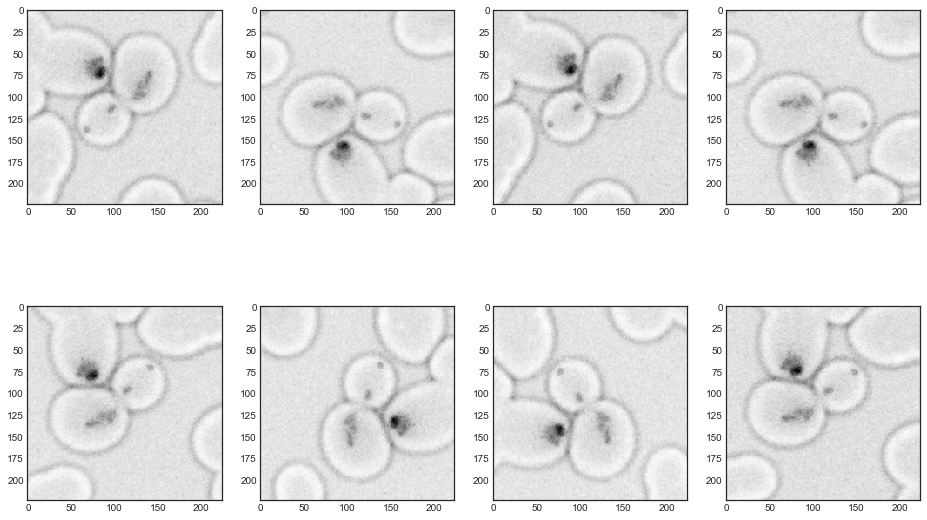

In [69]:
# print transformations
plt.style.use('seaborn-white')

c = 0
idx = 0
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
    ax.imshow(np.sum(im, axis = 0))
#     ax.imshow(im[c])

In [ ]:
plt.style.use('seaborn-white')

In [70]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

    for b in range(0,len(dl)):
        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [71]:
xs, ys =  load_epoch()

In [72]:
import seaborn as sns

(5017600,)
(5017600,)


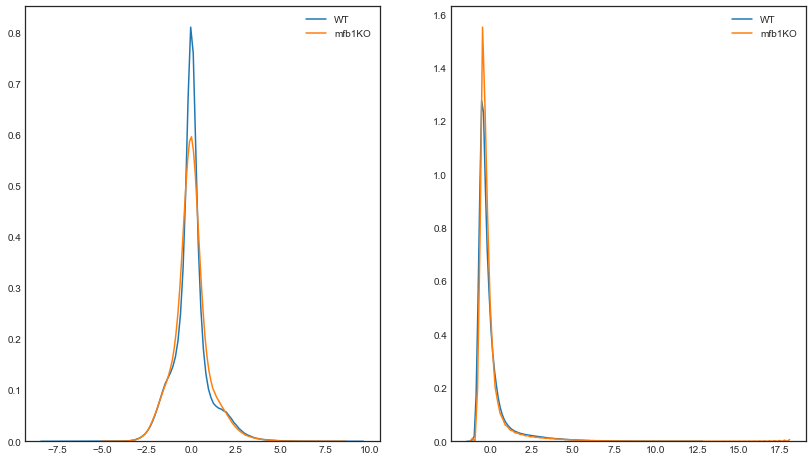

In [73]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 8))

for i in [2,3]:
    
    xs_clss = xs[ys == i] 
    xs_sub = xs_clss[:100,...]
    xs_sub = xs_sub.reshape(-1,2,50176)
    
    ch0, ch1 = np.ravel(xs_sub[:,0]), np.ravel(xs_sub[:,1])
    print(ch1.shape)

    sns.kdeplot(ch0, ax = axarr[0], label = data.classes[i])
    sns.kdeplot(ch1, ax = axarr[1], label = data.classes[i])
    
# axarr[0].set_xlim(-12,12);
# axarr[1].set_xlim(-10,18);   
# axarr[0].set_ylim(0,0.8);
# axarr[1].set_ylim(0,1.8);
axarr[1].legend()

In [74]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

630
2331
1623


# Training setup

In [75]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

Defining network architecture. 

In [10]:
arch = resnet18_c
# arch = resnet34_c

In [11]:
learn = ConvLearner.pretrained(arch, data, ps=0.25, opt_fn=optim.Adam, pretrained=False)

In [78]:
learn.unfreeze()

In [79]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 6272)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

In [80]:
wd=1e-5 # weight-decay/L2 regularization 

In [81]:
learn.lr_find(1e-10)

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 36/37 [00:16<00:00,  2.12it/s, loss=20.4]

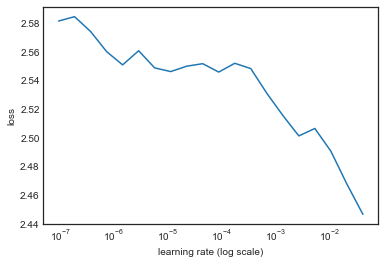

In [82]:
learn.sched.plot()

In [83]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                              
epoch      trn_loss   val_loss   accuracy   
    0      1.847074   2.891783   0.177778  
EPOCH 1 ---------------------------------------- STEP 1                                                                                                                                                              
    1      1.632542   1.400345   0.438095  
EPOCH 2 ---------------------------------------- STEP 2                                                                                                                                                              
    2      1.471544   1.494173   0.407937  
EPOCH 3 ---------------------------------------- STEP 3                                                                                                                              

[array([0.84945]), 0.6761904741090442]

In [84]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 8                                                                                                                                                              
epoch      trn_loss   val_loss   accuracy   
    0      1.337434   1.523902   0.436508  
EPOCH 1 ---------------------------------------- STEP 9                                                                                                                                                              
    1      1.140815   1.000279   0.592063  
EPOCH 2 ---------------------------------------- STEP 10                                                                                                                                                             
    2      1.041029   1.176563   0.54127   
EPOCH 3 ---------------------------------------- STEP 11                                                                                                                             

[array([0.69138]), 0.7317460304214841]

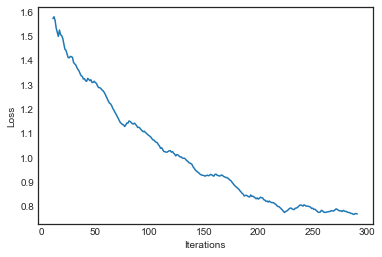

In [85]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

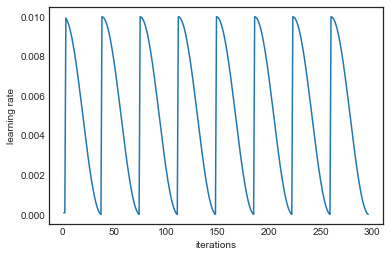

In [86]:
learn.sched.plot_lr()

In [87]:
%time learn.fit(4e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 16                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.670064   0.824587   0.693651  
EPOCH 1 ---------------------------------------- STEP 17                                                                                                                                                             
    1      0.610497   1.26827    0.520635  
EPOCH 2 ---------------------------------------- STEP 18                                                                                                                                                             
    2      0.60807    0.799615   0.698413  
EPOCH 3 ---------------------------------------- STEP 19                                                                                                                             

[array([0.45473]), 0.8285714304636396]

In [88]:
learn.save('yeast_v11.3_ResNet18_82_v1')

In [90]:
learn.load('yeast_v11.3_ResNet18_82_v1')

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [91]:
%time learn.fit(4e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v2')

EPOCH 0 ---------------------------------------- STEP 48                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.413727   0.758494   0.734921  
EPOCH 1 ---------------------------------------- STEP 49                                                                                                                                                             
    1      0.467803   0.845168   0.709524  
EPOCH 2 ---------------------------------------- STEP 50                                                                                                                                                             
    2      0.462696   1.104427   0.614286  
EPOCH 3 ---------------------------------------- STEP 51                                                                                                                             

[array([0.39121]), 0.8492063510985601]

In [92]:
learn.save('yeast_v11.3_ResNet18_85_v2')

In [93]:
%time learn.fit(1e-3, 1, cycle_len=8, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v3')

EPOCH 0 ---------------------------------------- STEP 64                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.252255   0.518438   0.811111  
EPOCH 1 ---------------------------------------- STEP 65                                                                                                                                                             
    1      0.275743   0.471854   0.82381   
EPOCH 2 ---------------------------------------- STEP 66                                                                                                                                                             
    2      0.25241    0.412414   0.855556  
EPOCH 3 ---------------------------------------- STEP 67                                                                                                                             

[array([0.35535]), 0.8682539692000737]

In [94]:
%time learn.fit(8e-4, 1, cycle_len=8, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v4')

EPOCH 0 ---------------------------------------- STEP 72                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.206974   0.525579   0.815873  
EPOCH 1 ---------------------------------------- STEP 73                                                                                                                                                             
    1      0.225892   0.496723   0.814286  
EPOCH 2 ---------------------------------------- STEP 74                                                                                                                                                             
    2      0.215464   0.390457   0.846032  
EPOCH 3 ---------------------------------------- STEP 75                                                                                                                             

[array([0.31969]), 0.8746031746031746]

In [95]:
%time learn.fit(6e-4, 1, cycle_len=12, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v5')

EPOCH 0 ---------------------------------------- STEP 80                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.185255   0.364193   0.873016  
EPOCH 1 ---------------------------------------- STEP 81                                                                                                                                                             
    1      0.186302   0.344433   0.861905  
EPOCH 2 ---------------------------------------- STEP 82                                                                                                                                                             
    2      0.18739    0.356885   0.868254  
EPOCH 3 ---------------------------------------- STEP 83                                                                                                                             

[array([0.29766]), 0.8857142866603912]

In [96]:
%time learn.fit(4e-4, 1, cycle_len=12, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v6')

EPOCH 0 ---------------------------------------- STEP 92                                                                                                                                                             
epoch      trn_loss   val_loss   accuracy   
    0      0.151221   0.310903   0.884127  
EPOCH 1 ---------------------------------------- STEP 93                                                                                                                                                             
    1      0.155919   0.311024   0.874603  
EPOCH 2 ---------------------------------------- STEP 94                                                                                                                                                             
    2      0.16438    0.357059   0.866667  
EPOCH 3 ---------------------------------------- STEP 95                                                                                                                             

[array([0.28936]), 0.8920634930095975]

In [97]:
%time learn.fit(1e-4, 1, cycle_len=24, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v7')

EPOCH 0 ---------------------------------------- STEP 104                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.145299   0.293483   0.893651  
EPOCH 1 ---------------------------------------- STEP 105                                                                                                                                                            
    1      0.145207   0.303987   0.887302  
EPOCH 2 ---------------------------------------- STEP 106                                                                                                                                                            
    2      0.140774   0.307472   0.892063  
EPOCH 3 ---------------------------------------- STEP 107                                                                                                                            

[array([0.29156]), 0.8888888888888888]

In [98]:
%time learn.fit(4e-5, 2, cycle_len=12, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v7')

EPOCH 0 ---------------------------------------- STEP 128                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.134733   0.287939   0.892063  
EPOCH 1 ---------------------------------------- STEP 129                                                                                                                                                            
    1      0.14557    0.293471   0.884127  
EPOCH 2 ---------------------------------------- STEP 130                                                                                                                                                            
    2      0.149932   0.290232   0.895238  
EPOCH 3 ---------------------------------------- STEP 131                                                                                                                            

[array([0.30089]), 0.8904761904761904]

In [99]:
%time learn.fit(1e-3, 2, cycle_len=8, cycle_mult=2, wds=wd, use_wd_sched=True, best_save_name='yeast_v11.3_ResNet18_v8')

EPOCH 0 ---------------------------------------- STEP 152                                                                                                                                                            
epoch      trn_loss   val_loss   accuracy   
    0      0.152412   0.544901   0.809524  
EPOCH 1 ---------------------------------------- STEP 153                                                                                                                                                            
    1      0.162773   0.361977   0.861905  
EPOCH 2 ---------------------------------------- STEP 154                                                                                                                                                            
    2      0.167606   0.427239   0.863492  
EPOCH 3 ---------------------------------------- STEP 155                                                                                                                            

[array([0.28945]), 0.8936507945968991]

In [219]:
learn.save('yeast_v11.3_ResNet18_v8_save')

In [ ]:
%time learn.fit(1e-4, 1, cycle_len=5, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-10, 1, cycle_len=3, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

In [ ]:
print(lbl2idx)

In [ ]:
learn.summary()

In [ ]:
learn.models.model

In [ ]:
learn.freeze_to(2)

In [ ]:
adjust = {0:22,
          1:14,
#           2:22,
          3:3,
          4:3,
         5:14,
         6:14
         }

# use_clr=(20,8, 0.95, 0.85),
%time learn.fit(1e-3, 1, cycle_len=8, wds=wd, use_wd_sched=True, adjust_class=adjust, best_save_name='YNet_v11.1_ResNet34_dihedral_ps025_IntNorm_rot90_rGauss_balanced_86_FT_mmr1')

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [12]:
## Load model:
learn.load('yeast_v11.3_ResNet18_v4')

In [13]:
learn.freeze_to(3)

In [14]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 6272)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [28]:
log_preds, y = learn.TTA(8) # run predictions with TTA

### Cross_validation evaluation

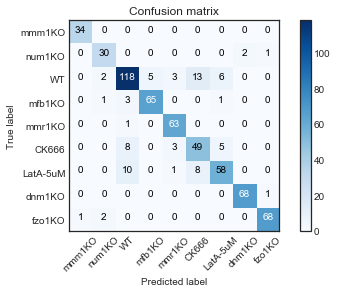

In [15]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [22]:
targ_names = ['mmm1KO', 'num1KO', 'WT', 'mfb1KO', 'mmr1KO', 'CK666', 'LatA', 'dnm1KO', 'fzo1KO']

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(accuracy_score(preds, y))

print(classification_report(preds, y, target_names=data.classes))

0.8873015873015873
             precision    recall  f1-score   support

     mmm1KO       0.97      1.00      0.99        34
     num1KO       0.86      0.94      0.90        32
         WT       0.83      0.81      0.82       143
     mfb1KO       0.94      0.94      0.94        70
     mmr1KO       0.90      0.98      0.94        64
      CK666       0.73      0.78      0.76        65
   LatA-5uM       0.89      0.77      0.82        81
     dnm1KO       0.99      0.99      0.99        70
     fzo1KO       0.97      0.96      0.96        71

avg / total       0.89      0.89      0.89       630



In [275]:
preds_noAct = []
y_noAct = []
for i in [2,3,4,0,1,7,8]:
    preds_noAct.extend(preds[y == i])
    y_noAct.extend(y[y==i])
    
print(accuracy_score(preds_noAct, y_noAct))
# print(classification_report(preds_noAct, y_noAct, target_names=['WT', 'mfb1KO', 'mmr1KO', 'mmm1KO', 'num1KO', 'dnm1KO', 'fzo1KO']))

0.9102040816326531


C:\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 9, does not match size of target_names, 7
  .format(len(labels), len(target_names))
C:\Anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         WT       1.00      1.00      1.00        35
     mfb1KO       0.83      0.91      0.87        32
     mmr1KO       0.83      0.94      0.88       124
     mmm1KO       0.94      0.93      0.94        71
     num1KO       0.91      0.98      0.95        65
     dnm1KO       0.00      0.00      0.00        11
     fzo1KO       0.00      0.00      0.00        10

avg / total       0.87      0.91      0.89       490



In [277]:
len(y_noAct), len(preds_noAct)

(490, 490)

## Test-set eval

In [ ]:
learn.models.model

In [29]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [30]:
embeddings = get_embeddings('14')

In [31]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(2331, 512)
(630, 512)
(1623, 512)
(2331,)
(630,)
(1623,)


In [139]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [140]:
# running PCA on embeddings
pca = []
n_components = 50
pca = PCA(n_components)

trn_pca_result = pca.fit_transform(embs_trn)
val_pca_result = pca.transform(embs_val)
test_pca_result = pca.transform(embs_test)

In [ ]:
#plotting compenent-wise cumulative explained variance (for PCA)

plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.plot(range(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [141]:
# running TSNE on embeddings

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs_trn)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2331 samples in 0.072s...
[t-SNE] Computed neighbors for 2331 samples in 4.776s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2331
[t-SNE] Computed conditional probabilities for sample 2000 / 2331
[t-SNE] Computed conditional probabilities for sample 2331 / 2331
[t-SNE] Mean sigma: 22.585397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.281429
[t-SNE] Error after 300 iterations: 1.201672


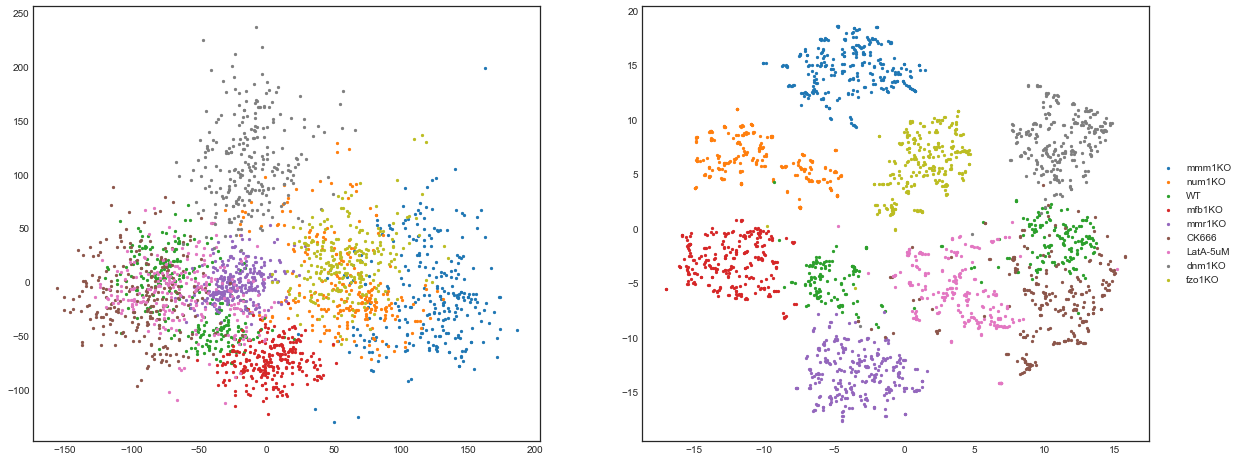

In [187]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(9):
    PCA_cls = trn_pca_result[y_trn == i]
    TSNE_cls = tsne_results[y_trn == i]
    
    axarr[0].scatter(PCA_cls[:,compA], PCA_cls[:,compB], label = data.classes[i], s = 5)
    axarr[1].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], label = data.classes[i], s =5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]
    val_PCA_cls = val_pca_result[y_val == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(val_PCA_cls[:,compA], val_PCA_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
print(lbl2idx_test)

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(7):
    trn_PCA_cls = trn_pca_result[y_trn == i]

    axarr[0].scatter(trn_PCA_cls[:,compA], trn_PCA_cls[:,compB], label = data.classes[i])
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[0].set_xlim(-15,45)
    axarr[0].set_ylim(-20,20)
    
for i in [0,1,3]:
    test_PCA_cls = test_pca_result[y_test == i]
    axarr[1].scatter(test_PCA_cls[:,compA], test_PCA_cls[:,compB], label = list(lbl2idx_test.keys())[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-15,45)
    axarr[1].set_ylim(-20,20)


In [ ]:
list(lbl2idx_test.keys())[0]

In [ ]:
# Generate 3D TSNE space from PCA of embeddings

tsne3D = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, learning_rate=50.0)
PCA2tSNE_results_3D = tsne3D.fit_transform(embs)

In [ ]:
tsne3D

In [ ]:
from mpl_toolkits import mplot3d

# magic command to make plots interactive.
# restart kernel if you want to switch to e.g. %matplotlib inline
%matplotlib notebook

In [ ]:
# 3D plotting - very slow interactivity atm...

fig = plt.figure()
ax = plt.axes(projection='3d')

compA = 0
compB = 1
compC = 2

for i in range(10):
    clss = PCA2tSNE_results_3D[y == i]
    cls_C = clss[0:500,:]
    ax.scatter3D(cls_C[:,compA], cls_C[:,compB], cls_C[:,compC])

In [19]:
import umap

In [49]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=50,
                      min_dist=1,negative_sample_rate=8,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

In [40]:
# UMAP_trn1 = UMAP_trn_embedding.embedding_
# UMAP_val1 = UMAP_trn_embedding.transform(embs_val)
# UMAP_test1 = UMAP_trn_embedding.transform(embs_test)

In [41]:
lbl2idx

{'01_mmm1KO': [0, 0, 'mmm1KO'],
 '01_num1KO': [1, 1, 'num1KO'],
 '02_WT': [2, 2, 'WT'],
 '02_mfb1KO': [3, 3, 'mfb1KO'],
 '02_mmr1KO': [4, 4, 'mmr1KO'],
 '03_CK666': [5, 5, 'CK666'],
 '03_LatA-5uM': [6, 6, 'LatA-5uM'],
 '03_WT': [7, 2, 'WT'],
 '03_dnm1KO': [8, 7, 'dnm1KO'],
 '03_fzo1KO': [9, 8, 'fzo1KO']}

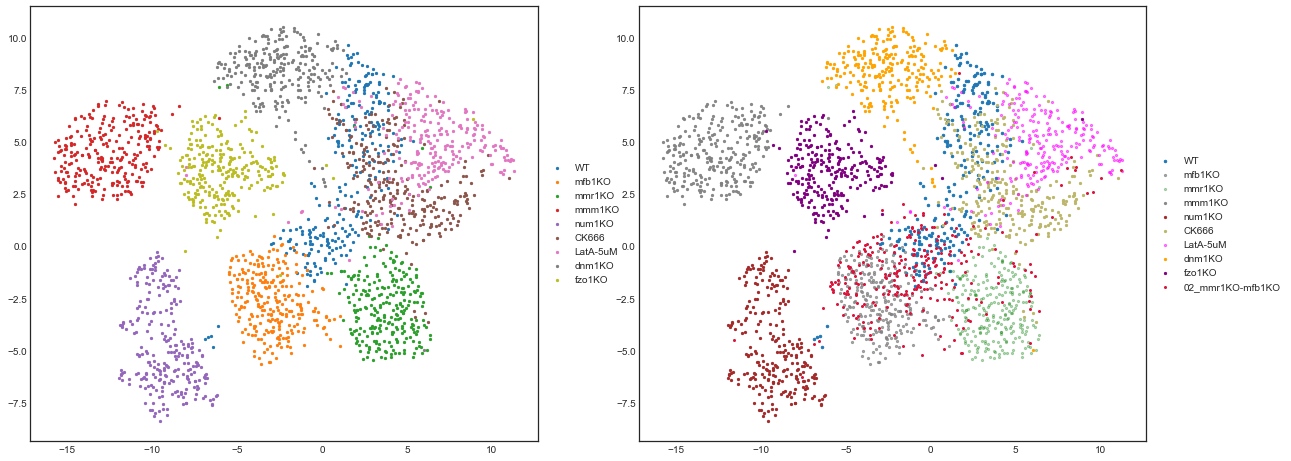

In [125]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in [2,3,4,0,1,5,6,7,8]:
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 2:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 6 )
    elif i == 3:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'gray', alpha = 0.7)
    elif i == 4:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'green', alpha = 0.3)
    elif i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'gray', alpha=0.9)
    elif i == 1:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'brown')    
    elif i == 5:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'darkkhaki')    
    elif i == 6:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'magenta', alpha = 0.5)    
    elif i == 7:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'orange')
    elif i == 8:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5, c = 'purple')
    
        

#     axarr[0].set_xlim(-22,15)
#     axarr[0].set_ylim(-15,12)
    
for i in [3]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], label = list(lbl2idx_test.keys())[i], marker= 'o', s = 4, c = 'crimson')
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     axarr[1].set_xlim(-22,15)
#     axarr[1].set_ylim(-15,12)


In [278]:
lbl2idx_test

{'01_WT': [0, 0, 'WT'],
 '01_mfb1KO': [1, 1, 'mfb1KO'],
 '01_mmr1KO': [2, 2, 'mmr1KO'],
 '02_mmr1KO-mfb1KO': [3, 3, 'mmr1KO-mfb1KO'],
 '03_LatA-05uM': [4, 4, 'LatA-05uM'],
 '03_axl1KO': [5, 5, 'axl1KO'],
 '03_bud1KO': [6, 6, 'bud1KO']}

In [51]:
UMAP_WT = UMAP_trn[y_trn == 2]

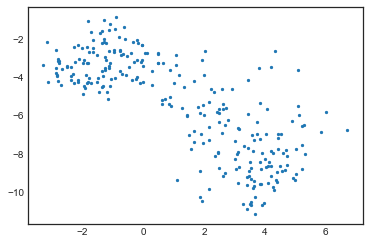

In [52]:
plt.scatter(UMAP_WT[:,0], UMAP_WT[:,1], s = 5)

In [281]:
len(data.trn_ds.fnames) + len(data.val_ds.fnames)

2961

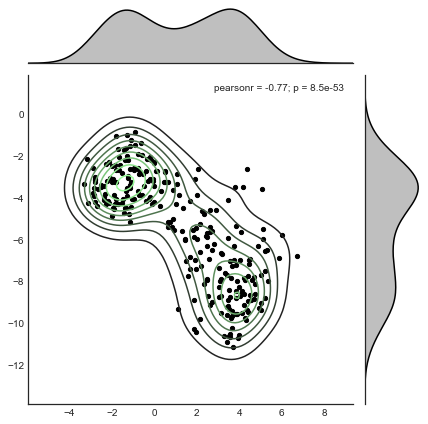

In [53]:
# Specify data

x = UMAP_WT[:,0]
y = UMAP_WT[:,1]
data1 = UMAP_WT

with sns.axes_style('white'):
    pal = sns.dark_palette("palegreen", as_cmap=True)
    sns.jointplot(x, y, kind='kde', shade=False, cmap=pal, color='k').plot_joint(plt.scatter, s=18, color='k')
    
#     , xlim=(-1.e3, 1e8), ylim=(-0.2e8, 1e8)


In [ ]:
lbl2idx_test)

### Visualizing train and test datasets as exposed by dataloader

### Inference

In [298]:
lbl2idx

{'01_mmm1KO': [0, 0, 'mmm1KO'],
 '01_num1KO': [1, 1, 'num1KO'],
 '02_WT': [2, 2, 'WT'],
 '02_mfb1KO': [3, 3, 'mfb1KO'],
 '02_mmr1KO': [4, 4, 'mmr1KO'],
 '03_CK666': [5, 5, 'CK666'],
 '03_LatA-5uM': [6, 6, 'LatA-5uM'],
 '03_WT': [7, 2, 'WT'],
 '03_dnm1KO': [8, 7, 'dnm1KO'],
 '03_fzo1KO': [9, 8, 'fzo1KO']}

In [156]:
lbl2idx_test

{'01_WT': [0, 0, 'WT'],
 '01_mfb1KO': [1, 1, 'mfb1KO'],
 '01_mmr1KO': [2, 2, 'mmr1KO'],
 '02_mmr1KO-mfb1KO': [3, 3, 'mmr1KO-mfb1KO'],
 '03_LatA-05uM': [4, 4, 'LatA-05uM'],
 '03_axl1KO': [5, 5, 'axl1KO'],
 '03_bud1KO': [6, 6, 'bud1KO']}

In [126]:
# test_log_preds, test_targs = learn.predict_with_targs('test')
test_log_preds, test_targs = learn.TTA(is_test=True, n_aug=8)
test_log_preds = np.mean(test_log_preds, axis=0)
testprobs = np.exp(test_log_preds)
test_preds = np.argmax(testprobs, axis=1)

In [141]:
test_robust = []
y_test_robust = []
for i in [0,1,2,3]:
    test_robust.extend(test_preds[test_targs == i])
    y_test_robust.extend(test_targs[test_targs==i])

In [142]:
np.array(y_test_robust)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 

In [143]:
y_test_robust = np.array(y_test_robust)
y_test_robust[y_test_robust == 3] = 5
y_test_robust[y_test_robust == 2] = 4
y_test_robust[y_test_robust == 1] = 3
y_test_robust[y_test_robust == 0] = 2

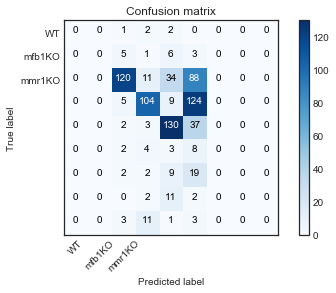

In [144]:
# np.array(test_robust)

cm = confusion_matrix(test_robust,y_test_robust)
plot_confusion_matrix(cm, ['WT', 'mfb1KO', 'mmr1KO'])

In [345]:
print(accuracy_score(test_robust, y_test_robust))
# print(classification_report(test_robust, y_test_robust, target_names=['WT', 'mfb1KO', 'mmr1KO']))

0.709278350515464


In [ ]:
preds_dict

In [346]:
# make predictions dictionary

h = 0
preds_dict = {}
for i, key in enumerate(lbl2idx_test.keys()):
    l = h
    h = h + list(data2.test_dl.dataset.src_idx).count(i)
    preds_dict[key] = list(test_preds[l:h])
    print(f"{key} predictions ready ({h - l} elements)")

01_WT predictions ready (140 elements)
01_mfb1KO predictions ready (140 elements)
01_mmr1KO predictions ready (205 elements)
02_mmr1KO-mfb1KO predictions ready (284 elements)
03_LatA-05uM predictions ready (309 elements)
03_axl1KO predictions ready (290 elements)
03_bud1KO predictions ready (255 elements)


In [347]:
preds_rel = {}
for key in preds_dict.keys():
    print(key)
    val = {cls: preds_dict[key].count(i)/len(preds_dict[key]) for i, cls in enumerate(data2.classes)}
    preds_rel[key]= val

01_WT
01_mfb1KO
01_mmr1KO
02_mmr1KO-mfb1KO
03_LatA-05uM
03_axl1KO
03_bud1KO


In [348]:
def plot_test_preds(targets, preds_rel):
    
    if not isinstance(targets, list):
        targets = [targets]
        
    x = math.ceil((int(len(targets)) /2)) # dynamic scaling of GridSpec
    sz = 4 * x # dynamic scaling of figuresize
    
    # plotting:
    plt.figure(figsize=(12,sz))
    gs1 = plt.GridSpec(x,2)
    gs1.update(wspace = 0.4)

    for i, targ in enumerate(targets):
        to_plot = [preds_rel[targ][key] for key in data.classes] # extracting data
        ax1 = plt.subplot(gs1[i])
        ax1.barh(data.classes, to_plot)
        ax1.set_title(targ)
        ax1.set_xlim(0,1)
    
    plt.show()

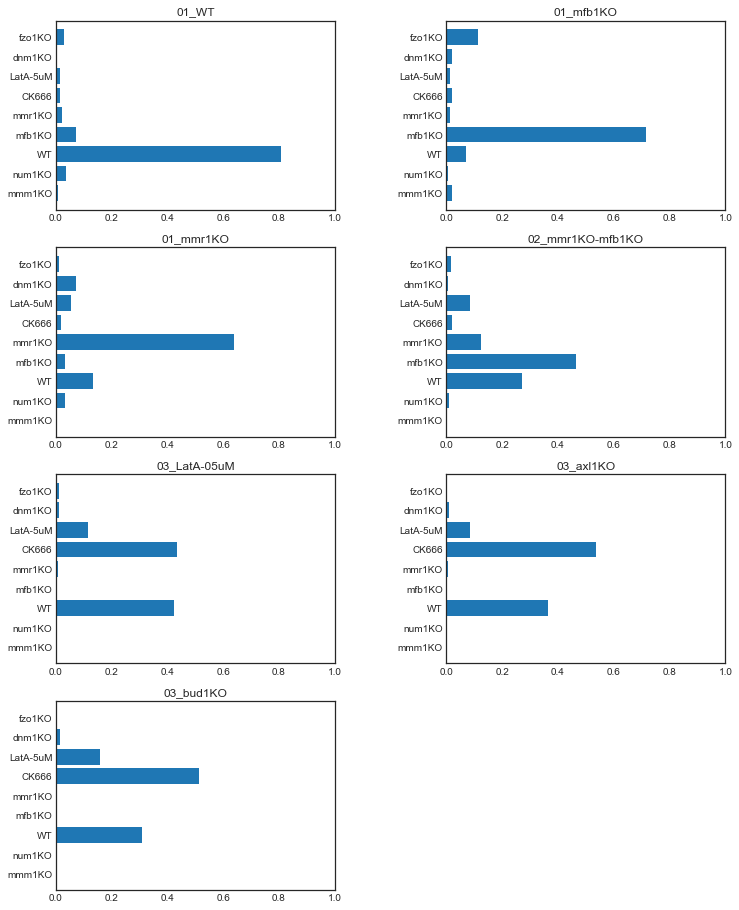

In [349]:
test_classes = list(lbl2idx_test.keys())

plot_test_preds(test_classes, preds_rel)
# plot_test_preds(['01_WT', '03_WT', '03_fzo1KO', '01_mfb1KO'], preds_rel)
# plot_test_preds(['01_WT', '01_mfb1KO', '01_mmr1KO'], preds_rel)

### Analyse images 

In [ ]:
log_preds, y = learn.TTA(8) # run predictions with TTA

#### Show random correct/incorrectly classified images:

In [80]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [81]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [82]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 6, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [83]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [103]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highest probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x, _ in enumerate(corr_lbl)]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

In [60]:
lbl2idx

{'01_mmm1KO': [0, 0, 'mmm1KO'],
 '01_num1KO': [1, 1, 'num1KO'],
 '02_WT': [2, 2, 'WT'],
 '02_mfb1KO': [3, 3, 'mfb1KO'],
 '02_mmr1KO': [4, 4, 'mmr1KO'],
 '03_CK666': [5, 5, 'CK666'],
 '03_LatA-5uM': [6, 6, 'LatA-5uM'],
 '03_WT': [7, 2, 'WT'],
 '03_dnm1KO': [8, 7, 'dnm1KO'],
 '03_fzo1KO': [9, 8, 'fzo1KO']}

In [100]:
list(lbl2idx.values())[7][2]

'WT'

'num1KO'

### Plot images according to predictions

Correctly classified


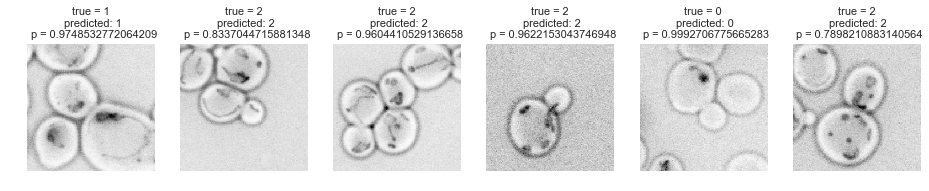

In [104]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

Incorrectly classified


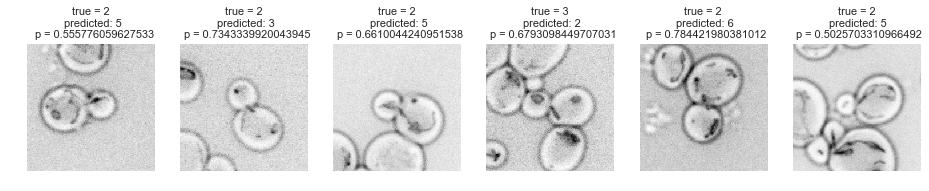

In [86]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [63]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[0:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

Most correctly classified WT


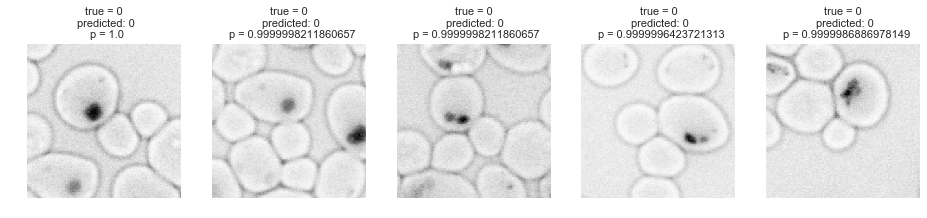

In [64]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified mmm1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

Most correctly classified WT


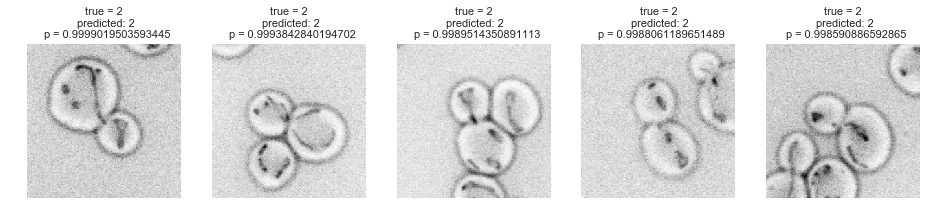

In [65]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified WT")

Most incorrectly classified WT


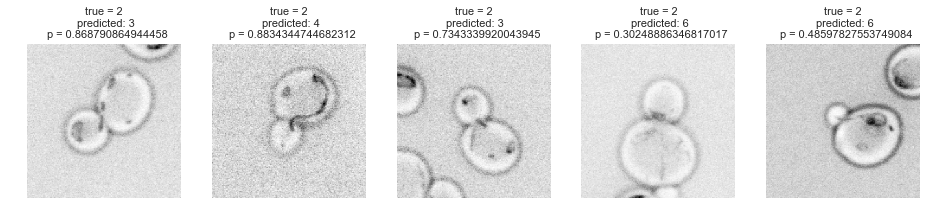

In [66]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, False), "Most incorrectly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified CK666")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(4, True), "Most correctly classified LatA")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(5, True), "Most correctly classified dnnm1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(6, True), "Most correctly classified fzo1KO")

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[1:5] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

In [ ]:
lbl2idx_